# Imports

In [ ]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset,random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import glob
import os
import numpy as np
from matplotlib import image as mpimg

In [ ]:
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return ssim(clean_image, denoised_image, data_range=1.0)

# Vaniila NN

Epoch 1/10, Loss: 0.0315
Epoch 2/10, Loss: 0.0021
Epoch 3/10, Loss: 0.0016
Epoch 4/10, Loss: 0.0019
Epoch 5/10, Loss: 0.0012
Epoch 6/10, Loss: 0.0014
Epoch 7/10, Loss: 0.0012
Epoch 8/10, Loss: 0.0015
Epoch 9/10, Loss: 0.0010
Epoch 10/10, Loss: 0.0008


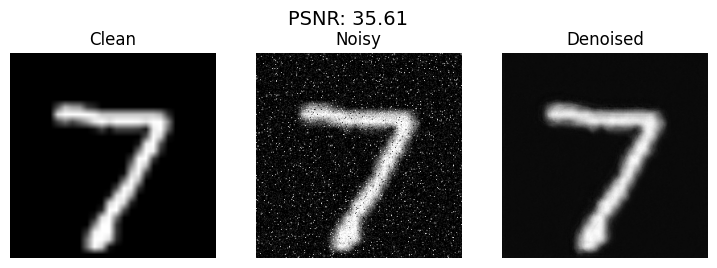

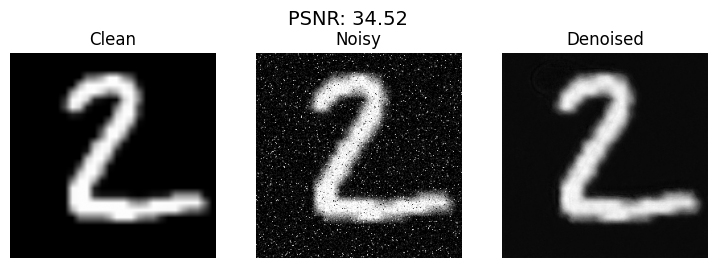

In [ ]:
# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return ssim(clean_image, denoised_image, data_range=1.0)

# ----------------------------
# Noise Function
# ----------------------------
def add_noise(x, gaussian_std=0.1, sp_amount=0.02):
    x_noisy = x + torch.randn_like(x) * gaussian_std
    x_noisy = torch.clamp(x_noisy, 0, 1)
    B, C, H, W = x_noisy.shape
    num_sp = int(sp_amount * H * W)
    for i in range(B):
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 1.0  # Salt
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 0.0  # Pepper
    return x_noisy

# ----------------------------
# Dataset and Loader
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Train dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(Subset(train_dataset, range(1000)), batch_size=8, shuffle=True)

# Test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(Subset(test_dataset, range(10)), batch_size=2, shuffle=False)

# ----------------------------
# UNet Model
# ----------------------------
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 10  # for demo, increase for real training

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break


# Vanilla NN - MRI Images

In [ ]:
# ----------------------------
# Custom MRI Dataset
# ----------------------------
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Get all image files inside the folder
        self.files = glob.glob(root_dir + "/*")
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("L")  # convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image   # no labels, just the image

# ----------------------------
# Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# ----------------------------
# Load Dataset
# ----------------------------
dataset = MRIDataset("./Images", transform=transform)
print(f"Found {len(dataset)} MRI images")

# ----------------------------
# Split into train(10) / val(5) / test(5)
# ----------------------------
train_size, val_size, test_size = 10, 5, 5
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Found 20 MRI images


Found 20 MRI images
Epoch 1/20, Train Loss: 0.5891, Val Loss: 16198.8415
Epoch 2/20, Train Loss: 0.2320, Val Loss: 400.5886
Epoch 3/20, Train Loss: 0.0846, Val Loss: 5.9348
Epoch 4/20, Train Loss: 0.0353, Val Loss: 2.2940
Epoch 5/20, Train Loss: 0.0221, Val Loss: 0.5277
Epoch 6/20, Train Loss: 0.0165, Val Loss: 0.0255
Epoch 7/20, Train Loss: 0.0121, Val Loss: 0.0136
Epoch 8/20, Train Loss: 0.0089, Val Loss: 0.0099
Epoch 9/20, Train Loss: 0.0082, Val Loss: 0.0082
Epoch 10/20, Train Loss: 0.0068, Val Loss: 0.0063
Epoch 11/20, Train Loss: 0.0064, Val Loss: 0.0057
Epoch 12/20, Train Loss: 0.0059, Val Loss: 0.0054
Epoch 13/20, Train Loss: 0.0054, Val Loss: 0.0049
Epoch 14/20, Train Loss: 0.0056, Val Loss: 0.0047
Epoch 15/20, Train Loss: 0.0050, Val Loss: 0.0045
Epoch 16/20, Train Loss: 0.0053, Val Loss: 0.0045
Epoch 17/20, Train Loss: 0.0056, Val Loss: 0.0042
Epoch 18/20, Train Loss: 0.0048, Val Loss: 0.0044
Epoch 19/20, Train Loss: 0.0048, Val Loss: 0.0041
Epoch 20/20, Train Loss: 0.0051, 

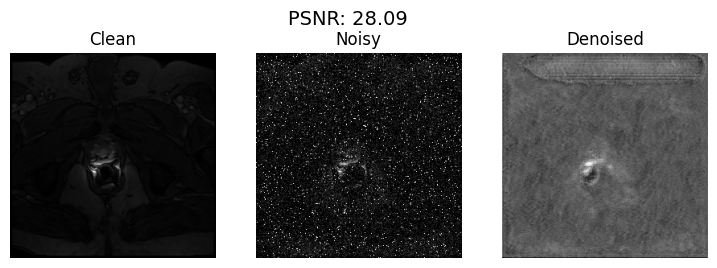

In [ ]:
# ----------------------------
# Custom MRI Dataset
# ----------------------------
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        # Get all image files inside the folder
        self.files = glob.glob(root_dir + "/*")
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)
        return image   # no labels, just the image

# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return ssim(clean_image, denoised_image, data_range=1.0)

# ----------------------------
# Noise Function
# ----------------------------
def add_noise(x, gaussian_std=0.1, sp_amount=0.02):
    x_noisy = x + torch.randn_like(x) * gaussian_std
    x_noisy = torch.clamp(x_noisy, 0, 1)
    B, C, H, W = x_noisy.shape
    num_sp = int(sp_amount * H * W)
    for i in range(B):
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 1.0  # Salt
        coords = [torch.randint(0, s, (num_sp,)) for s in (H, W)]
        x_noisy[i, 0, coords[0], coords[1]] = 0.0  # Pepper
    return x_noisy

# ----------------------------
# Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# ----------------------------
# Load Dataset
# ----------------------------
dataset = MRIDataset("./Images", transform=transform)
print(f"Found {len(dataset)} MRI images")

# Split into train(10) / val(5) / test(5)
train_size, val_size, test_size = 10, 5, 5
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------
# UNet Model
# ----------------------------
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 20  # for demo, increase for real training

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss = 0
    for images in train_loader:   # only images now
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)
            noisy_images = add_noise(images).to(device)
            outputs = model(noisy_images)
            val_loss += criterion(outputs, images).item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        noisy_images = add_noise(images, gaussian_std=0.1, sp_amount=0.02).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break


# K-Space example

Printing a regular image and noisy image against its k-space representation

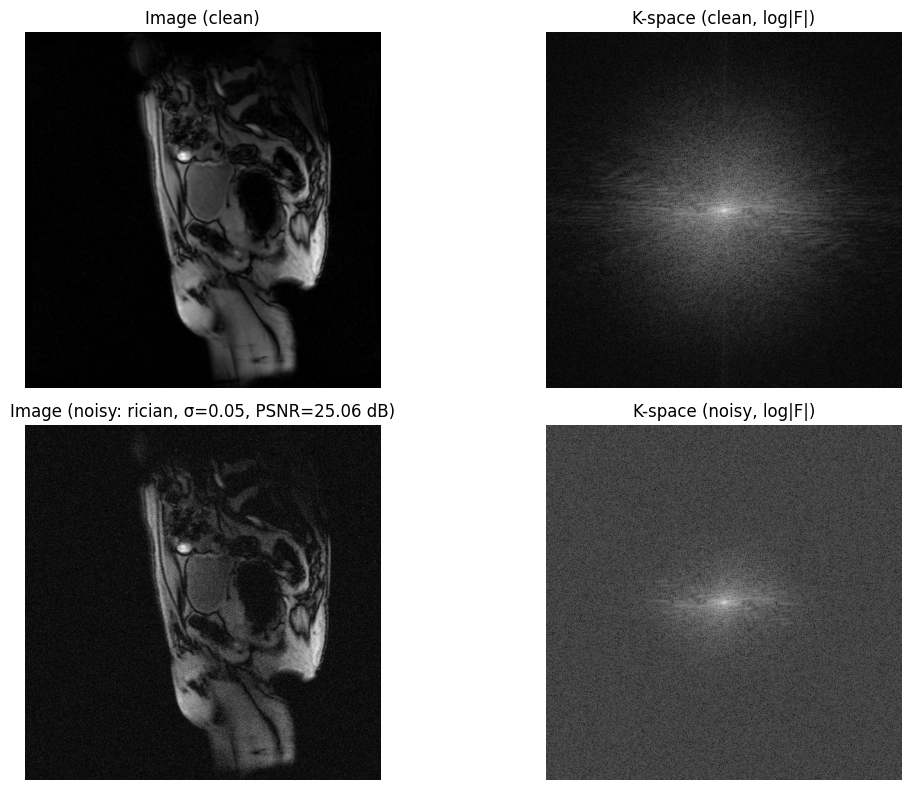

In [ ]:
# ----- paths -----
img_path = "example_image2.png"
os.makedirs("images", exist_ok=True)

# ----- load PNG -----
img = mpimg.imread(img_path)  # shape: (H,W) grayscale or (H,W,3/4) RGB(A)

# convert to float32 in [0,1]
if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255.0
else:
    img = img.astype(np.float32)

# drop alpha if present
if img.ndim == 3 and img.shape[2] == 4:
    img = img[..., :3]

# convert to grayscale if RGB
if img.ndim == 3:
    # perceptual luminance weights
    img = img[..., 0]*0.2126 + img[..., 1]*0.7152 + img[..., 2]*0.0722

# optional normalization (keep dynamic range sane)
img = (img - img.min()) / (img.max() - img.min() + 1e-8)

# ----- compute k-space for clean image -----
kspace = np.fft.fftshift(np.fft.fft2(img))
kspace_logmag = np.log1p(np.abs(kspace))

# ===== noise config =====
NOISE_TYPE = "rician"  # "gaussian" or "rician"
NOISE_STD = 0.05         # std in [0,1] image space
SEED = 42                # for reproducibility

rng = np.random.default_rng(SEED)

def add_gaussian_noise(x, sigma):
    n = rng.normal(loc=0.0, scale=sigma, size=x.shape).astype(np.float32)
    y = x + n
    return np.clip(y, 0.0, 1.0)

def add_rician_noise(x, sigma):
    # MRI-like noise: magnitude of two orthogonal Gaussian components
    n1 = rng.normal(0.0, sigma, size=x.shape).astype(np.float32)
    n2 = rng.normal(0.0, sigma, size=x.shape).astype(np.float32)
    y = np.sqrt((x + n1)**2 + n2**2)
    # rescale to [0,1] for viewing
    y = (y - y.min()) / (y.max() - y.min() + 1e-8)
    return np.clip(y, 0.0, 1.0)

# pick noise model
if NOISE_TYPE == "gaussian":
    img_noisy = add_gaussian_noise(img, NOISE_STD)
elif NOISE_TYPE == "rician":
    img_noisy = add_rician_noise(img, NOISE_STD)
else:
    raise ValueError("NOISE_TYPE must be 'gaussian' or 'rician'")

# ----- compute k-space for noisy image -----
kspace_noisy = np.fft.fftshift(np.fft.fft2(img_noisy))
kspace_noisy_logmag = np.log1p(np.abs(kspace_noisy))

# optional: compute PSNR for reference
mse = np.mean((img_noisy - img)**2)
psnr = 10.0 * np.log10(1.0 / (mse + 1e-12))

# ----- plot originals vs noisy -----
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Image (clean)")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(kspace_logmag, cmap="gray")
plt.title("K-space (clean, log|F|)")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(img_noisy, cmap="gray")
plt.title(f"Image (noisy: {NOISE_TYPE}, σ={NOISE_STD}, PSNR={psnr:.2f} dB)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(kspace_noisy_logmag, cmap="gray")
plt.title("K-space (noisy, log|F|)")
plt.axis("off")

plt.tight_layout()
plt.savefig(os.path.join("images", "clean_vs_noisy_kspace.png"), dpi=200, bbox_inches="tight")
plt.show()


# Vanilla NN - MRI Images with K-space

Found 20 MRI images
Epoch 1/20, Train Loss: 0.4498, Val Loss: 0.0102
Epoch 2/20, Train Loss: 0.0893, Val Loss: 0.0241
Epoch 3/20, Train Loss: 0.0352, Val Loss: 0.0257
Epoch 4/20, Train Loss: 0.0207, Val Loss: 0.0094
Epoch 5/20, Train Loss: 0.0135, Val Loss: 0.0052
Epoch 6/20, Train Loss: 0.0102, Val Loss: 0.0046
Epoch 7/20, Train Loss: 0.0084, Val Loss: 0.0041
Epoch 8/20, Train Loss: 0.0093, Val Loss: 0.0041
Epoch 9/20, Train Loss: 0.0079, Val Loss: 0.0039
Epoch 10/20, Train Loss: 0.0071, Val Loss: 0.0038
Epoch 11/20, Train Loss: 0.0063, Val Loss: 0.0038
Epoch 12/20, Train Loss: 0.0059, Val Loss: 0.0038
Epoch 13/20, Train Loss: 0.0053, Val Loss: 0.0038
Epoch 14/20, Train Loss: 0.0060, Val Loss: 0.0038
Epoch 15/20, Train Loss: 0.0054, Val Loss: 0.0038
Epoch 16/20, Train Loss: 0.0045, Val Loss: 0.0040
Epoch 17/20, Train Loss: 0.0050, Val Loss: 0.0037
Epoch 18/20, Train Loss: 0.0057, Val Loss: 0.0036
Epoch 19/20, Train Loss: 0.0051, Val Loss: 0.0036
Epoch 20/20, Train Loss: 0.0041, Val Lo

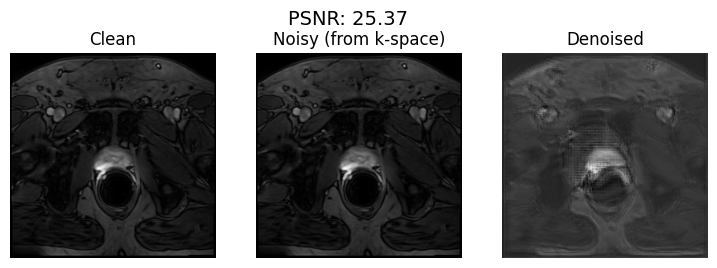

In [ ]:

# ----------------------------
# Custom MRI Dataset
# ----------------------------
class MRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = glob.glob(root_dir + "/*")
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image   # shape [1,H,W]

# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    return psnr(clean_image.cpu().numpy(), denoised_image.cpu().numpy(), data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    return ssim(clean_image.cpu().numpy(), denoised_image.cpu().numpy(), data_range=1.0)

# ----------------------------
# K-space utilities
# ----------------------------
def fft2c(img):
    """ Apply centered 2D FFT (image -> kspace) """
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(img, dim=(-2,-1))), dim=(-2,-1))

def ifft2c(kspace):
    """ Apply centered 2D IFFT (kspace -> image) """
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(kspace, dim=(-2,-1))), dim=(-2,-1)).real

def add_kspace_noise(img, gaussian_std=0.02):
    """ Add Gaussian noise in k-space """
    kspace = fft2c(img)                       # [B,1,H,W] -> kspace
    noise = (torch.randn_like(kspace) + 1j*torch.randn_like(kspace)) * gaussian_std
    kspace_noisy = kspace + noise             # add complex noise
    img_noisy = ifft2c(kspace_noisy)          # back to image domain
    return torch.clamp(img_noisy, 0, 1)

# ----------------------------
# Transform
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# ----------------------------
# Load Dataset
# ----------------------------
dataset = MRIDataset("./Images", transform=transform)
print(f"Found {len(dataset)} MRI images")

train_size, val_size, test_size = 10, 5, 5
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# ----------------------------
# UNet Model
# ----------------------------
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,
    in_channels=1,
    classes=1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
num_epochs = 20

for epoch in range(num_epochs):
    # ---- Training ----
    model.train()
    running_loss = 0
    for images in train_loader:
        images = images.to(device)                  # clean
        noisy_images = add_kspace_noise(images).to(device)  # noisy from k-space

        outputs = model(noisy_images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)
            noisy_images = add_kspace_noise(images).to(device)
            outputs = model(noisy_images)
            val_loss += criterion(outputs, images).item()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        noisy_images = add_kspace_noise(images).to(device)
        outputs = model(noisy_images)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            denoised = outputs[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(9,3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1,3,1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,2)
            plt.title("Noisy (from k-space)")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1,3,3)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break


# DnCNN

* DnCNN-S is trained for specific known Gaussian noise levels

* DnCNN-B is trained for blind Gaussian denoising (i.e. unknown noise level over a range)

* DnCNN-3 is a single model trained to handle three general restoration tasks: blind Gaussian denoising, single image super-resolution (SISR), and JPEG deblocking.

https://github.com/yjn870/DnCNN-pytorch

In [ ]:
!git clone https://github.com/yjn870/DnCNN-pytorch.git DnCNN_pytorch

Cloning into 'DnCNN_pytorch'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23 (from 1)
Receiving objects: 100% (23/23), 4.18 MiB | 27.62 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
import random
import torch

def set_seed(seed: int = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
set_seed()

In [ ]:
import os

data_path = 'Images'
png_folder = os.path.join(data_path)

checkpoints_path = '/checkpoints'
os.makedirs(checkpoints_path, exist_ok=True)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image

class HighFrequencyDataset(Dataset):
    def __init__(self, images_path):
        self.images_path = images_path
        self.images = self.read_images()

    def read_images(self) -> torch.Tensor:
        image_file_paths = [f for f in os.listdir(self.images_path) if f.lower().endswith('.png')]
        images = [Image.open(os.path.join(self.images_path, img_path)) for img_path in image_file_paths]
        return self.transform_images(images)

    def transform_images(self, images: list[Image]) -> torch.Tensor:
        transform = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor(),
        ])
        return torch.stack([transform(image) for image in images])

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx) -> torch.Tensor:
        return self.images[idx]

In [ ]:
dataset = HighFrequencyDataset(png_folder)

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=0)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
print(len(train_dataset))

16


In [ ]:
import torch


def add_gaussian_noise(x: torch.Tensor, max_sigma: float, min_sigma: float = 0):
    sigmas = torch.rand(x.size(0), 1, 1, 1, device=x.device) * (max_sigma - min_sigma) + min_sigma
    noise = torch.randn_like(x) * sigmas
    return x + noise, sigmas

def add_rician_noise(img: torch.Tensor, max_sigma: float, min_sigma: float = 0) -> tuple[torch.Tensor, float]:
    """
    Add Rician noise to an image tensor.

    Args:
        img (torch.Tensor): Input image (float tensor).
        sigma (float): Standard deviation of the underlying Gaussian noise.

    Returns:
        torch.Tensor: Noisy image with Rician-distributed values.
    """
    sigma = torch.rand(1).item() * (max_sigma - min_sigma) + min_sigma
    # Generate Gaussian noise with mean=0, std=sigma
    n1 = torch.normal(mean=0.0, std=sigma, size=img.shape, device=img.device)
    n2 = torch.normal(mean=0.0, std=sigma, size=img.shape, device=img.device)

    # Apply Rician formula
    noisy_img = torch.sqrt((img + n1) ** 2 + n2 ** 2)

    return noisy_img, sigma

## Option 1

Epoch 1/3: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


Epoch 2/3, Loss: 1.5212


Epoch 2/3: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Epoch 3/3, Loss: 0.8743


Epoch 3/3: 100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


Epoch 4/3, Loss: 0.3968


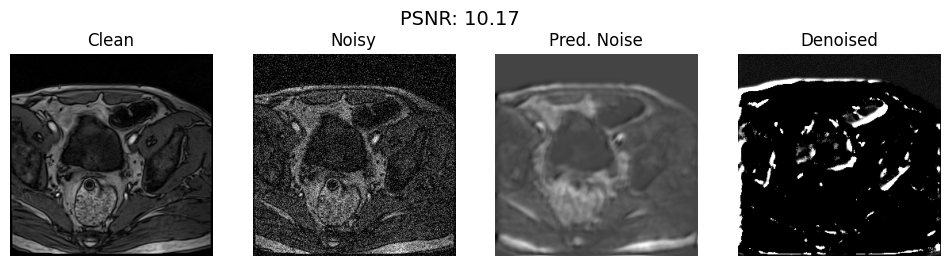

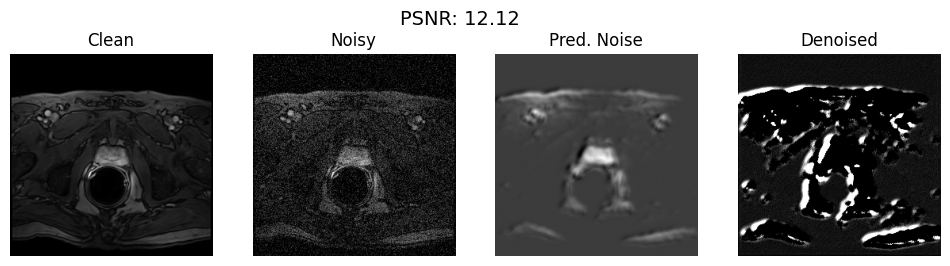

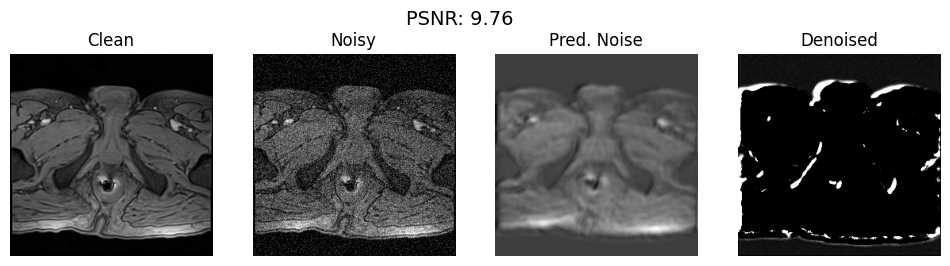

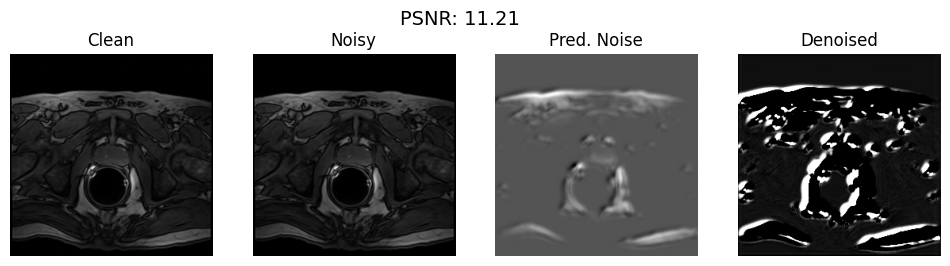

In [ ]:
# ----------------------------
# Imports
# ----------------------------
import sys
sys.path.append("./DnCNN_pytorch")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
from tqdm import tqdm

from DnCNN_pytorch.model import DnCNN

# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return ssim(clean_image, denoised_image, data_range=1.0)


# ----------------------------
# DnCNN-B Model
# ----------------------------
model = DnCNN(num_layers=20)  # from repo, hardcoded 17-layer blind Gaussian model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
EPOCHS = 3
NOISE_STD = 0.15

for epoch in range(1, EPOCHS + 1):
    pbar = tqdm(iter(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")

    model.train()
    running_loss = 0

    for images in pbar:
      images = images.to(device)
        # repeat grayscale to 3 channels for DnCNN-B
      images_3c = images.repeat(1, 3, 1, 1)
      noisy_images, _ = add_gaussian_noise(images_3c, NOISE_STD)

      outputs = model(noisy_images)
      loss = criterion(outputs, images_3c)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Visualize Test Images (Improved)
# ----------------------------
model.eval()
with torch.no_grad():
    for images in val_loader:
        images = images.to(device)
        images_3c = images.repeat(1, 3, 1, 1)
        noisy_images, _ = add_gaussian_noise(images_3c, NOISE_STD)
        noisy_images = torch.clamp(noisy_images, 0., 1.)

        # Predict noise
        predicted_noise = model(noisy_images)
        # Denoised image: noisy minus predicted noise
        denoised_images = torch.clamp(noisy_images - predicted_noise, 0., 1.)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            noise_pred = predicted_noise[i, 0].cpu()
            denoised = denoised_images[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(12, 3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1, 4, 1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.title("Pred. Noise")
            plt.imshow(noise_pred, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break

## Option 2

Using device: cuda
Starting training...


Epoch 1/3: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it, Loss=1.104264]


Epoch 1/3, Average Loss: 1.104264


Epoch 2/3: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it, Loss=0.767247]


Epoch 2/3, Average Loss: 0.767247


Epoch 3/3: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it, Loss=0.638217]


Epoch 3/3, Average Loss: 0.638217
Training completed!

DENOISING RESULTS


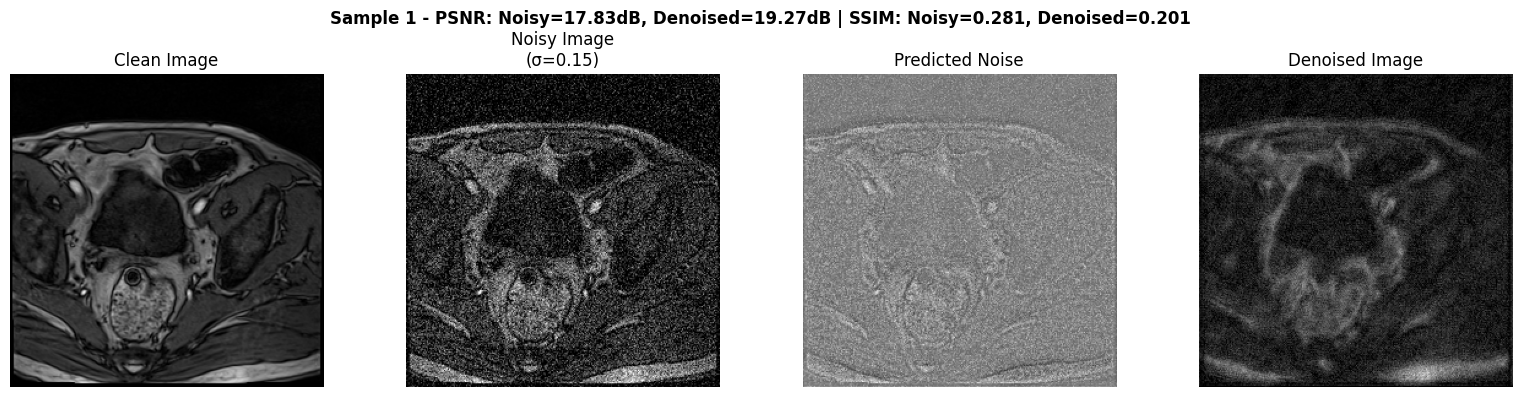


Sample 1 Metrics:
  PSNR - Noisy: 17.831 dB, Denoised: 19.269 dB (Improvement: 1.439 dB)
  SSIM - Noisy: 0.2813, Denoised: 0.2014 (Improvement: -0.0799)


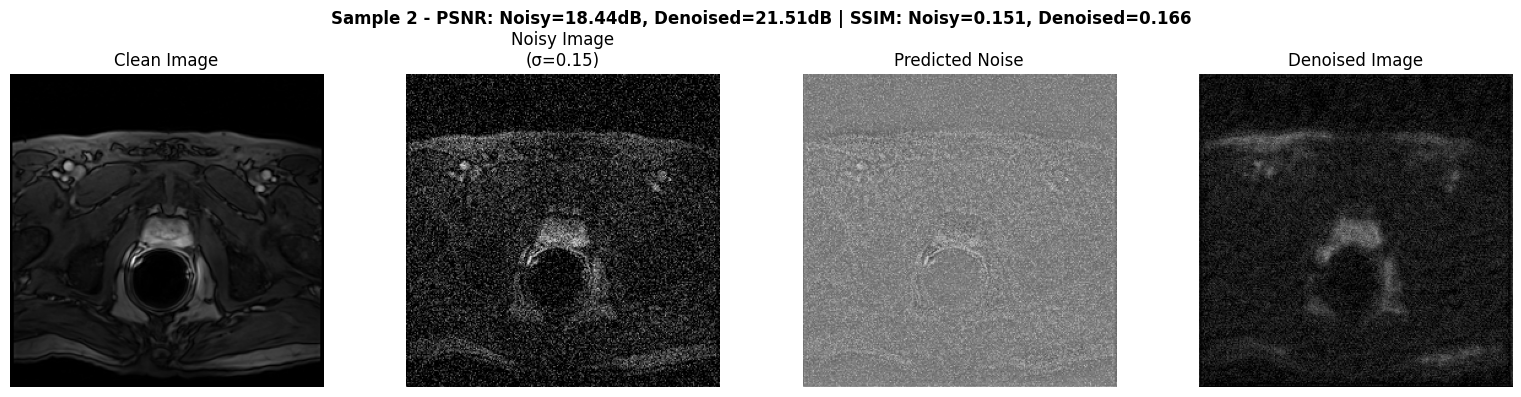


Sample 2 Metrics:
  PSNR - Noisy: 18.436 dB, Denoised: 21.510 dB (Improvement: 3.074 dB)
  SSIM - Noisy: 0.1512, Denoised: 0.1659 (Improvement: 0.0146)


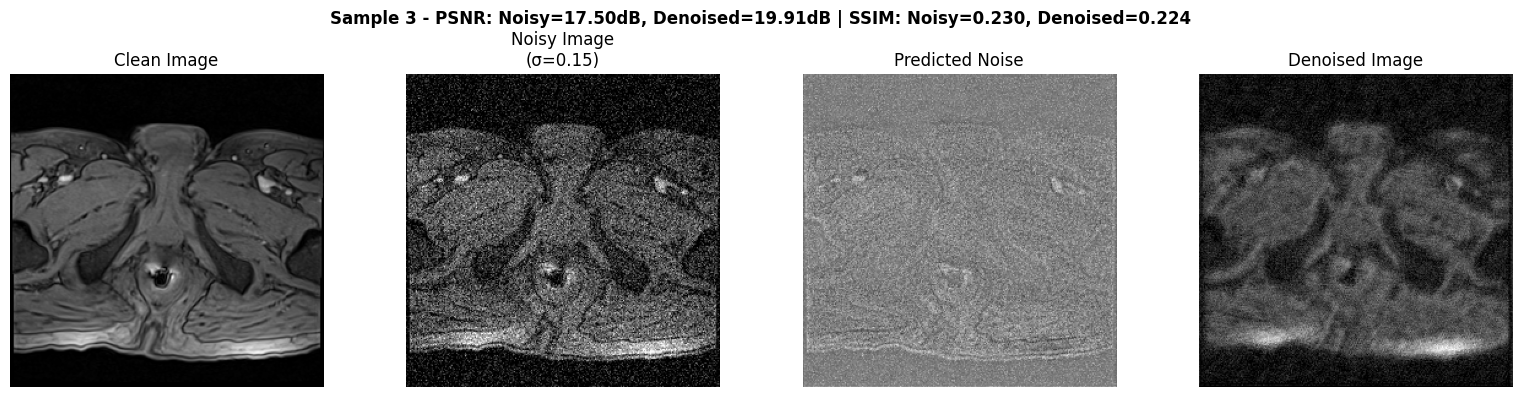


Sample 3 Metrics:
  PSNR - Noisy: 17.502 dB, Denoised: 19.905 dB (Improvement: 2.403 dB)
  SSIM - Noisy: 0.2301, Denoised: 0.2237 (Improvement: -0.0065)

Model saved as 'dncnn_denoising_model.pth'
Training and evaluation completed successfully!


In [ ]:
# ----------------------------
# Complete DnCNN Image Denoising Code
# ----------------------------
import sys
sys.path.append("./DnCNN_pytorch")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
import numpy as np
from tqdm import tqdm

from DnCNN_pytorch.model import DnCNN

# ----------------------------
# Set random seeds for reproducibility
# ----------------------------
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ----------------------------
# Noise addition function
# ----------------------------
def add_gaussian_noise(images, noise_std=0.15):
    """Add Gaussian noise to images"""
    noise = torch.randn_like(images) * noise_std
    noisy_images = images + noise
    return torch.clamp(noisy_images, 0., 1.), noise

# ----------------------------
# PSNR and SSIM computation
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    """Compute PSNR between clean and denoised images"""
    clean_np = clean_image.cpu().numpy()
    denoised_np = denoised_image.cpu().numpy()
    return psnr(clean_np, denoised_np, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    """Compute SSIM between clean and denoised images"""
    clean_np = clean_image.cpu().numpy()
    denoised_np = denoised_image.cpu().numpy()
    return ssim(clean_np, denoised_np, data_range=1.0)

# ----------------------------
# DnCNN Model Setup
# ----------------------------
model = DnCNN(num_layers=17)  # Standard DnCNN with 17 layers
model = model.to(device)

# ----------------------------
# Training setup
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-7)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)

# ----------------------------
# Training Loop
# ----------------------------
EPOCHS = 3
NOISE_STD = 0.15

print("Starting training...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, images in enumerate(pbar):
        images = images.to(device)

        # Convert grayscale to 3 channels for DnCNN (if needed)
        if images.shape[1] == 1:
            images = images.repeat(1, 3, 1, 1)

        # Add noise
        noisy_images, actual_noise = add_gaussian_noise(images, NOISE_STD)

        # Forward pass - DnCNN predicts the noise
        predicted_noise = model(noisy_images)

        # Loss is between predicted noise and actual noise
        loss = criterion(predicted_noise, actual_noise)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update progress bar
        pbar.set_postfix({'Loss': f'{loss.item():.6f}'})

        # Limit training batches for demo (remove this for full training)
        if batch_idx > 100:  # Train on first 100 batches only for demo
            break

    scheduler.step()
    avg_loss = running_loss / min(len(train_loader), 101)
    print(f"Epoch {epoch+1}/{EPOCHS}, Average Loss: {avg_loss:.6f}")

print("Training completed!")

# ----------------------------
# Evaluation and Visualization
# ----------------------------
def visualize_denoising_results(model, data_loader, num_samples=3):
    """Visualize denoising results"""
    model.eval()

    with torch.no_grad():
        for batch_idx, images in enumerate(data_loader):
            images = images.to(device)

            # Convert to 3 channels if needed
            if images.shape[1] == 1:
                images_3c = images.repeat(1, 3, 1, 1)
            else:
                images_3c = images

            # Add noise
            noisy_images, _ = add_gaussian_noise(images_3c, NOISE_STD)

            # Predict noise
            predicted_noise = model(noisy_images)

            # Denoised image = noisy image - predicted noise
            denoised_images = torch.clamp(noisy_images - predicted_noise, 0., 1.)

            # Visualize results
            for i in range(min(num_samples, images.shape[0])):
                # Use first channel for visualization
                clean = images[i, 0] if images.shape[1] == 1 else images_3c[i, 0]
                noisy = noisy_images[i, 0]
                noise_pred = predicted_noise[i, 0]
                denoised = denoised_images[i, 0]

                # Compute metrics
                psnr_noisy = compute_psnr(clean, noisy)
                psnr_denoised = compute_psnr(clean, denoised)
                ssim_noisy = compute_ssim(clean, noisy)
                ssim_denoised = compute_ssim(clean, denoised)

                # Create visualization
                fig, axes = plt.subplots(1, 4, figsize=(16, 4))
                fig.suptitle(f'Sample {i+1} - PSNR: Noisy={psnr_noisy:.2f}dB, Denoised={psnr_denoised:.2f}dB | SSIM: Noisy={ssim_noisy:.3f}, Denoised={ssim_denoised:.3f}',
                           fontsize=12, fontweight='bold')

                # Clean image
                axes[0].imshow(clean.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
                axes[0].set_title('Clean Image', fontsize=12)
                axes[0].axis('off')

                # Noisy image
                axes[1].imshow(noisy.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
                axes[1].set_title(f'Noisy Image\n(σ={NOISE_STD})', fontsize=12)
                axes[1].axis('off')

                # Predicted noise
                noise_display = (noise_pred.cpu().numpy() + 1) / 2  # Normalize for display
                axes[2].imshow(noise_display, cmap='gray', vmin=0, vmax=1)
                axes[2].set_title('Predicted Noise', fontsize=12)
                axes[2].axis('off')

                # Denoised image
                axes[3].imshow(denoised.cpu().numpy(), cmap='gray', vmin=0, vmax=1)
                axes[3].set_title('Denoised Image', fontsize=12)
                axes[3].axis('off')

                plt.tight_layout()
                plt.show()

                # Print detailed metrics
                print(f"\nSample {i+1} Metrics:")
                print(f"  PSNR - Noisy: {psnr_noisy:.3f} dB, Denoised: {psnr_denoised:.3f} dB (Improvement: {psnr_denoised-psnr_noisy:.3f} dB)")
                print(f"  SSIM - Noisy: {ssim_noisy:.4f}, Denoised: {ssim_denoised:.4f} (Improvement: {ssim_denoised-ssim_noisy:.4f})")

            break  # Only process first batch

# ----------------------------
# Test the denoising performance
# ----------------------------
print("\n" + "="*60)
print("DENOISING RESULTS")
print("="*60)

visualize_denoising_results(model, val_loader, num_samples=3)

# ----------------------------
# Function to denoise a single image
# ----------------------------
def denoise_single_image(model, image_path=None, image_tensor=None):
    """Denoise a single image"""
    model.eval()

    if image_path:
        from PIL import Image
        # Load image from path
        img = Image.open(image_path).convert('L')  # Convert to grayscale
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        image_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    if image_tensor is None:
        raise ValueError("Either image_path or image_tensor must be provided")

    image_tensor = image_tensor.to(device)

    # Convert to 3 channels
    if image_tensor.shape[1] == 1:
        image_3c = image_tensor.repeat(1, 3, 1, 1)
    else:
        image_3c = image_tensor

    # Add noise (for demonstration)
    noisy_image, _ = add_gaussian_noise(image_3c, NOISE_STD)

    with torch.no_grad():
        # Predict noise
        predicted_noise = model(noisy_image)
        # Denoise
        denoised_image = torch.clamp(noisy_image - predicted_noise, 0., 1.)

    return {
        'clean': image_tensor[0, 0] if image_tensor.shape[1] == 1 else image_3c[0, 0],
        'noisy': noisy_image[0, 0],
        'denoised': denoised_image[0, 0]
    }

# ----------------------------
# Save the trained model
# ----------------------------
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'noise_std': NOISE_STD,
}, 'dncnn_denoising_model.pth')

print(f"\nModel saved as 'dncnn_denoising_model.pth'")
print("Training and evaluation completed successfully!")

# DNCNN - B

In [1]:
!git clone https://github.com/yjn870/DnCNN-pytorch.git DnCNN_pytorch

Cloning into 'DnCNN_pytorch'...
remote: Enumerating objects: 23, done.
remote: Total 23 (delta 0), reused 0 (delta 0), pack-reused 23 (from 1)
Receiving objects: 100% (23/23), 4.18 MiB | 18.61 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
import random
import torch

def set_seed(seed: int = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed()

In [5]:
import os

data_path = 'Images'
png_folder = os.path.join(data_path)

checkpoints_path = '/checkpoints'
os.makedirs(checkpoints_path, exist_ok=True)

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image

class HighFrequencyDataset(Dataset):
    def __init__(self, images_path):
        self.images_path = images_path
        self.images = self.read_images()

    def read_images(self) -> torch.Tensor:
        image_file_paths = [f for f in os.listdir(self.images_path) if f.lower().endswith('.png')]
        images = [Image.open(os.path.join(self.images_path, img_path)) for img_path in image_file_paths]
        return self.transform_images(images)

    def transform_images(self, images: list[Image]) -> torch.Tensor:
        transform = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor(),
        ])
        return torch.stack([transform(image) for image in images])

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx) -> torch.Tensor:
        return self.images[idx]

In [7]:
dataset = HighFrequencyDataset(png_folder)

In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=0)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [9]:
print(len(train_dataset))

16


In [10]:
import torch


def add_gaussian_noise(x: torch.Tensor, max_sigma: float, min_sigma: float = 0):
    sigmas = torch.rand(x.size(0), 1, 1, 1, device=x.device) * (max_sigma - min_sigma) + min_sigma
    noise = torch.randn_like(x) * sigmas
    return x + noise, sigmas

def add_rician_noise(img: torch.Tensor, max_sigma: float, min_sigma: float = 0) -> tuple[torch.Tensor, float]:
    """
    Add Rician noise to an image tensor.

    Args:
        img (torch.Tensor): Input image (float tensor).
        sigma (float): Standard deviation of the underlying Gaussian noise.

    Returns:
        torch.Tensor: Noisy image with Rician-distributed values.
    """
    sigma = torch.rand(1).item() * (max_sigma - min_sigma) + min_sigma
    # Generate Gaussian noise with mean=0, std=sigma
    n1 = torch.normal(mean=0.0, std=sigma, size=img.shape, device=img.device)
    n2 = torch.normal(mean=0.0, std=sigma, size=img.shape, device=img.device)

    # Apply Rician formula
    noisy_img = torch.sqrt((img + n1) ** 2 + n2 ** 2)

    return noisy_img, sigma

Epoch 1/3: 100%|██████████| 1/1 [00:02<00:00,  2.63s/it]


Epoch 1/3, Loss: 0.9126


Epoch 2/3: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Epoch 2/3, Loss: 0.9460


Epoch 3/3: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Epoch 3/3, Loss: 0.3914


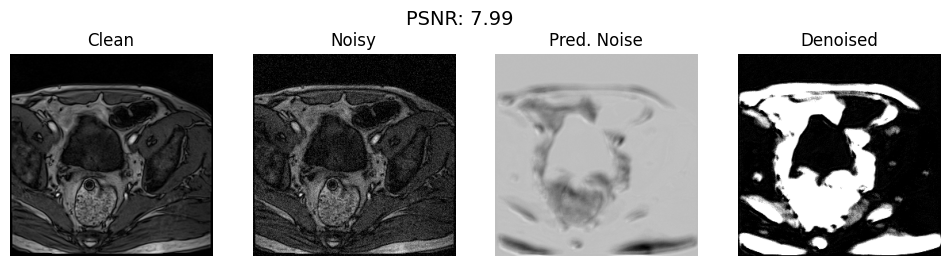

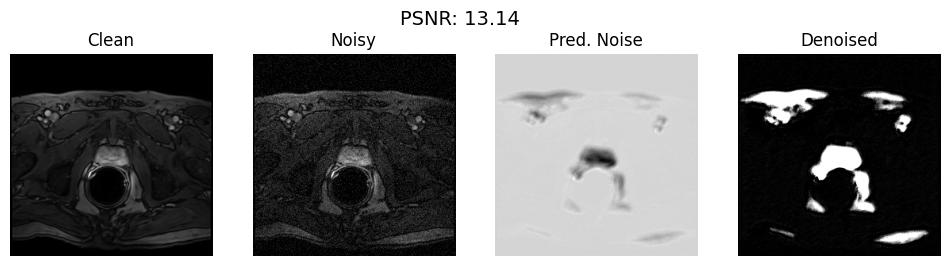

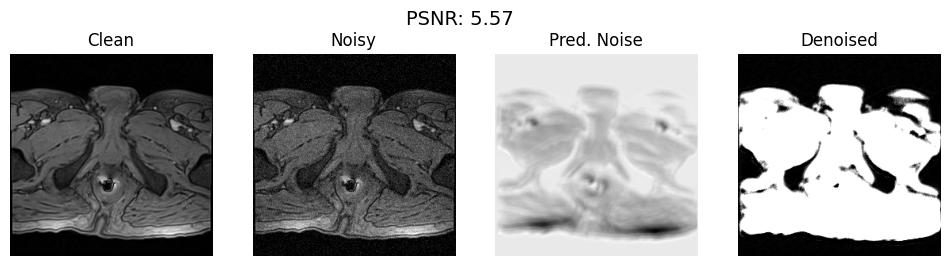

In [11]:
# ----------------------------
# Imports
# ----------------------------
import sys
sys.path.append("./DnCNN_pytorch")

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import random

from DnCNN_pytorch.model import DnCNN

# ----------------------------
# PSNR and SSIM
# ----------------------------
def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()
    return ssim(clean_image, denoised_image, data_range=1.0)

# ----------------------------
# DnCNN-B Model
# ----------------------------
model = DnCNN(num_layers=20)  # Blind Gaussian denoising
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ----------------------------
# Optimizer and Loss
# ----------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# ----------------------------
# Training Loop
# ----------------------------
EPOCHS = 3

for epoch in range(1, EPOCHS + 1):
    pbar = tqdm(iter(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")

    model.train()
    running_loss = 0

    for images in pbar:
        images = images.to(device)
        # repeat grayscale to 3 channels for DnCNN-B
        images_3c = images.repeat(1, 3, 1, 1)

        # pick a random noise level σ ~ U(0,55)/255
        sigma = random.uniform(0, 55) / 255.0
        noise = torch.randn_like(images_3c) * sigma
        noisy_images = torch.clamp(images_3c + noise, 0., 1.)

        # Model predicts noise
        predicted_noise = model(noisy_images)
        target_noise = noisy_images - images_3c

        loss = criterion(predicted_noise, target_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch}/{EPOCHS}, Loss: {running_loss/len(train_loader):.4f}")

# ----------------------------
# Visualize Test Images
# ----------------------------
model.eval()
with torch.no_grad():
    for images in val_loader:
        images = images.to(device)
        images_3c = images.repeat(1, 3, 1, 1)

        # sample a noise level for validation too
        sigma = random.uniform(0, 55) / 255.0
        noise = torch.randn_like(images_3c) * sigma
        noisy_images = torch.clamp(images_3c + noise, 0., 1.)

        # Predict noise
        predicted_noise = model(noisy_images)
        denoised_images = torch.clamp(noisy_images - predicted_noise, 0., 1.)

        for i in range(images.shape[0]):
            clean = images[i, 0].cpu()
            noisy = noisy_images[i, 0].cpu()
            noise_pred = predicted_noise[i, 0].cpu()
            denoised = denoised_images[i, 0].cpu()
            psnr_score = compute_psnr(clean, denoised)

            plt.figure(figsize=(12, 3))
            plt.suptitle(f"PSNR: {psnr_score:.2f}", fontsize=14)

            plt.subplot(1, 4, 1)
            plt.title("Clean")
            plt.imshow(clean, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.title("Noisy")
            plt.imshow(noisy, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.title("Pred. Noise")
            plt.imshow(noise_pred, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.title("Denoised")
            plt.imshow(denoised, cmap='gray')
            plt.axis('off')

            plt.show()
        break
